<a href="https://colab.research.google.com/github/madhugopinathan/deep-nlu/blob/master/yelp_reviews_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yelp Reviews EDA

**Save a copy in drive**

In [1]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz

--2019-08-24 10:48:39--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196146755 (187M) [application/x-tar]
Saving to: ‘yelp_review_full_csv.tgz’

yelp_review_full_cs 100%[===================>] 187.06M  56.6MB/s    in 3.3s    

2019-08-24 10:48:43 (56.6 MB/s) - ‘yelp_review_full_csv.tgz’ saved [196146755/196146755]



In [2]:
!tar xvfz yelp_review_full_csv.tgz

yelp_review_full_csv/
yelp_review_full_csv/train.csv
yelp_review_full_csv/readme.txt
yelp_review_full_csv/test.csv


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import svds

In [0]:
import pandas as pd

In [0]:
pd.options.display.max_colwidth=-1

In [0]:
import seaborn as sns

In [0]:
import spacy

In [0]:
nlp = spacy.load('en')

## Load Reviews: Browse Restaurant Reviews


In [0]:
DATA_DIR = "./yelp_review_full_csv/"

In [0]:
df = pd.read_csv(DATA_DIR + "train.csv", header=None, names=['rating', 'review'])

In [12]:
df[df.review.str.contains("indian")].sample(3)

,rating,review
637442,3,"= = = = = = WEEKDAY LUNCH BUFFET = = = = = =\n\nHey Hey, it's a new Buffet! :-)\n\nStopped in here for lunch today, joined by Mike C., & Jackie C.\n\nTHE GOOD:\n\n* This place features a comfortable north facing dining room with your choice of booth or table seating.\n\n* There were 27 food items all together (counting salad ingredients separately but not dressings and garnishes), plus hot Indian Tea. This is a good selection for an Indian Lunch Buffet.\n\n* We were brought Dosas, which are a treat often reserved for dinner & weekends at Indian restaurants.\n\n* The staff was very friendly and appreciative. :-)\n\nYES, THERE WERE A FEW ISSUES:\n\n* They open at 11 AM but weren't ready to go for a few minutes more. The staff seemed disorganized for them having been open at least 11 days now. (I've dined at more than one much bigger Buffet where I was their first customer ever and everything was perfect... China City in Avondale on 11/24/10 for example, with a 125 item presentation and not a flaw to be found with the place! The same was true of LIn's on Baseline and China Olive in Sun City.)\n\n* Much of the hot food here was out at near room temperature! This is not ok! Even 40 minutes later the two soups, for example, were barely warm. :-(\n\n* Speaking of soups, there should have been small Melmac or china bowls for the soupy dishes, not styrofoam cups! China mugs for the tea would be more appropriate than styrofoam cups, too. :-|\n\nThe flavors of the foods were good, and the selection balanced. They just need to run a tighter ship, so for now it's 3 Stars and Best Wishes for Aachi Southindian Kitchen. :-)\n\nWeekday Lunch Buffet: $8.99"
12071,3,"Service was fast. Prices are very reasonable. The food is good by Champaign standards and OK by larger market standards. I had the Chicken Vindaloo which had a nice flavor but was lacking in heat. The naan was nice but just slightly burnt. \n\nI would go back if I was in champaign and jonesin for some indian food, but i wouldnt seek it out as a fantastic restaurant"
386242,4,"I love indian food and I am used to eat a lot of it. Thali is very small and usually packed so most of the time, I call in to order and go pick up my food.\nI've tried almost everything but I stick to the butter chicken as it is my favourite East-Indian dish. \nNaan bread is usually not that warm which sucks because it would taste better if it was served very hot.\nBe careful, 80% of their food is very spicy!\n+++: they sell Thumbs Up :)."


## Extract cuisines using Spacy Named Entity Recognition (NER)



*   GPE: Geo-political entity
*   NORP: Nationalities, religious, political groups



In [0]:
text = """Definitely not the best Indian food I have had. 
          Good for them they are in Vegas where other Indian restaurants 
          are pretty bad as well."""

In [14]:
doc = nlp(text)
for ent in doc.ents:
    print(ent.label_, ent.lower_, ent.start, ent.end)

NORP indian 4 5
GPE vegas 17 18
NORP indian 20 21


In [15]:
doc[4:5], doc[17:18]

(Indian, Vegas)

### Build a cuisine - word co-occurrence matrix



*   cuisine2idx: map cuisine to index

    * idx2cuisine: map index to cuisine
    
*   token2idx: map other tokens to indices

    * idx2token: map index to token



In [0]:
def get_cuisine_idx(cuisine):
    return cuisine2idx.setdefault(cuisine, len(cuisine2idx))

def get_token_idx(token):
    return token2idx.setdefault(token, len(token2idx))

In [0]:
def build_cuisine_token_mat(df,ws=10):
    row = []
    col = []
    data = []
    
    def do_count_tokens(cuisine, tokens):
        for tok in tokens:
            if len(tok.ent_type_) > 0 or tok.is_stop or tok.is_punct:
                continue
            row.append(get_cuisine_idx(cuisine.lower_))
            col.append(get_token_idx(tok.lower_))
            data.append(1.)
    
    for doc in nlp.pipe(df.review):
        for ent in doc.ents:
            # NORP: nationalities, religious, political groups
            if ent.label_ == "NORP": 
                # count left side window
                do_count_tokens(ent, doc[ent.start-ws:ent.start]) 
                # count right side window
                do_count_tokens(ent, doc[ent.end:ent.end+ws])
    
    return sparse.csr_matrix((data, (row, col)), 
                             shape=(len(cuisine2idx), len(token2idx)))

In [18]:
%%time
np.random.seed(42)
cuisine2idx = {}
token2idx = {}
small_df = df.sample(20000)
cuisine_token_mat = build_cuisine_token_mat(small_df)

CPU times: user 6min, sys: 6.96 s, total: 6min 7s
Wall time: 6min 8s


In [0]:
idx2token = {v:k for k,v in token2idx.items()}
idx2cuisine = {v:k for k,v in cuisine2idx.items()}

In [0]:
def get_top_cuisine_indices(mat,n):
    rowsum = np.squeeze(np.asarray(mat.sum(axis=1)))
    return np.argsort(rowsum)[::-1][:n]

In [21]:
for idx in get_top_cuisine_indices(cuisine_token_mat,20):
    print(idx,idx2cuisine[idx])

3 mexican
15 chinese
13 italian
2 thai
19 french
5 asian
12 american
24 japanese
10 indian
0 greek
56 korean
75 irish
4 vietnamese
14 venetian
20 hawaiian
27 cheese
78 spanish
111 german
63 brazilian
22 european


In [0]:
def get_top_token_indices(mat,n):
    rowsum = np.squeeze(np.asarray(mat.sum(axis=0)))
    return np.argsort(rowsum)[::-1][:n]

In [23]:
for idx in get_top_token_indices(cuisine_token_mat,20):
    print(idx,idx2token[idx])

9  
16 food
8 good
6 place
61 like
65 restaurant
24 great
207 ordered
78 restaurants
335 better
63 menu
157 service
245 time
54 try
548 salad
466 best
83 nice
59 authentic
746 chicken
51 little


### How sparse is the matrix?

In [24]:
cuisine_token_mat.shape

(812, 6841)

In [25]:
cuisine_token_mat.nnz

21898

In [26]:
cuisine_token_mat.nnz/np.prod(cuisine_token_mat.shape) * 100

0.39421108457194126

### Visualize top cuisines x top tokens

In [0]:
def get_cuisine_token_df(mat,n=25):
    cuisine_indices = get_top_cuisine_indices(mat, n)
    token_indices = get_top_token_indices(mat, n)

    data = []
    co_mat = np.zeros((len(cuisine_indices), len(token_indices)))
    for i,cidx in zip(range(n),cuisine_indices):
        for j, jidx in zip(range(n),token_indices):
            data.append((idx2cuisine[cidx], idx2token[jidx], 
                         cuisine_token_mat[cidx, jidx]))
            
    columns=['cuisine','token','freq']
    df = pd.DataFrame(data,columns=columns)
    return df.pivot(*columns)

In [0]:
ct_df = get_cuisine_token_df(cuisine_token_mat)

In [29]:
ct_df.head()

token,,authentic,best,better,chicken,dishes,find,food,good,got,great,know,like,little,love,menu,nice,ordered,place,restaurant,restaurants,salad,service,time,try
cuisine,,,,,,,,,,,,,,,,,,,,,,,,,
american,51.0,4.0,0.0,3.0,3.0,6.0,4.0,29.0,15.0,7.0,7.0,6.0,23.0,3.0,3.0,17.0,0.0,5.0,13.0,14.0,1.0,5.0,5.0,5.0,1.0
asian,56.0,3.0,3.0,13.0,4.0,6.0,2.0,44.0,20.0,3.0,8.0,4.0,22.0,8.0,4.0,5.0,9.0,3.0,17.0,15.0,13.0,3.0,10.0,5.0,2.0
brazilian,12.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,3.0,0.0,7.0,1.0,3.0,3.0
canadian,8.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
cheese,27.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,1.0,0.0,5.0,3.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0


In [0]:
ct_df.drop(columns=[' ','food'], inplace=True)

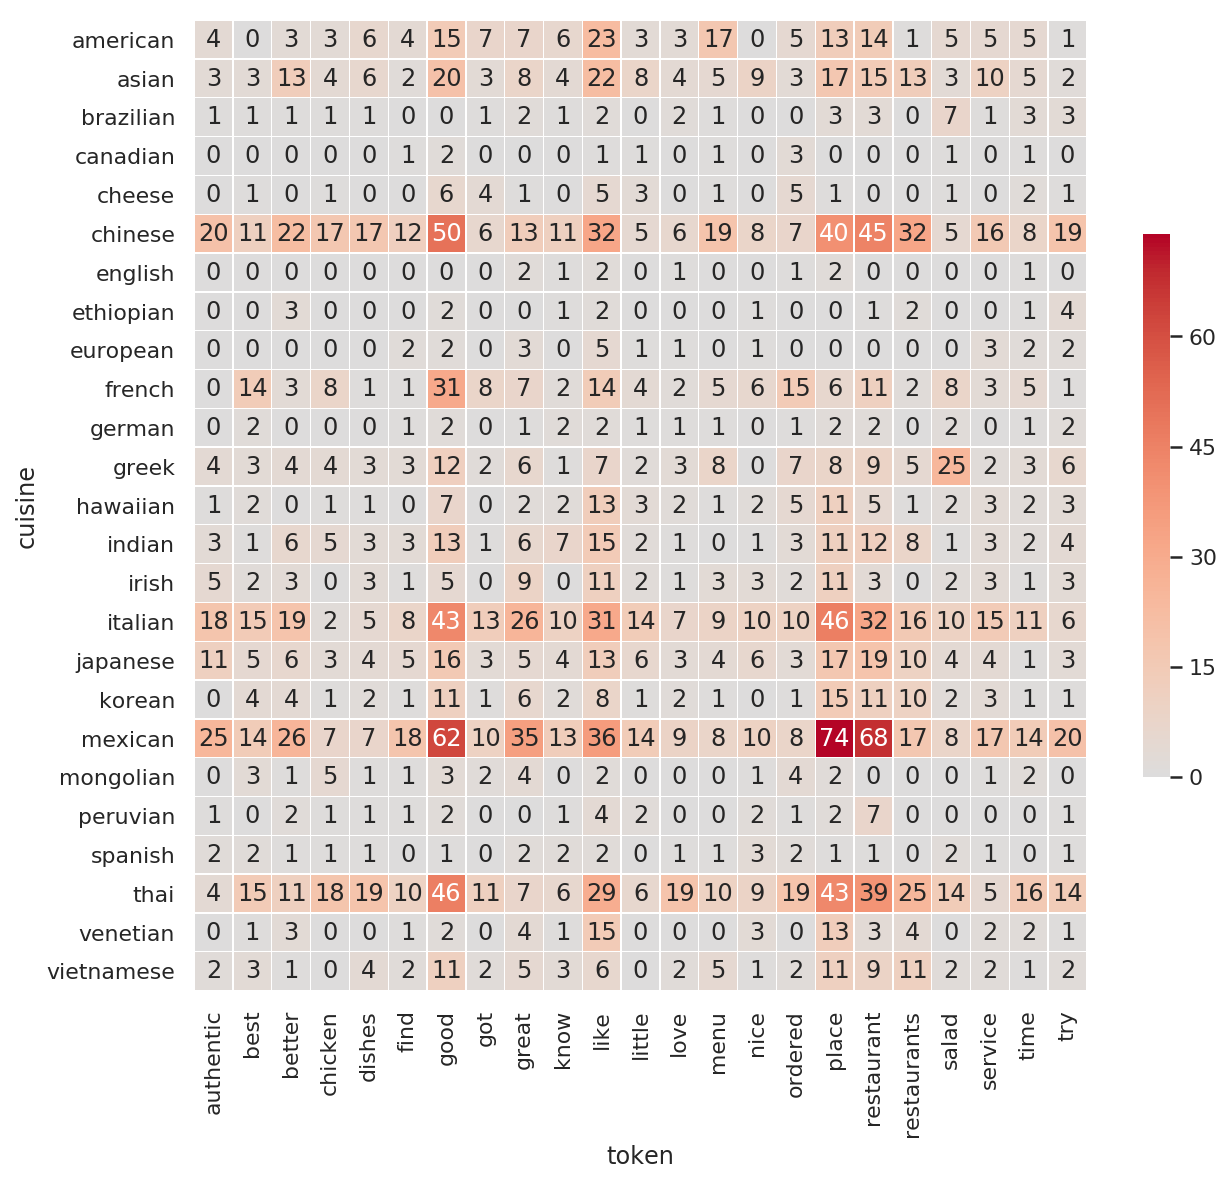

In [31]:
fig = plt.figure(figsize=(10, 10))  
sns.set(style='white')  
ax = sns.heatmap(ct_df, 
                 cmap="coolwarm",
                 annot=True, 
                 center=0, square=True, 
                 linewidths=0.2,cbar_kws={"shrink": 0.5})

## Co-occurrence matrix reweighting using Pointwise Mutual Information


[Positive Pointwise Mutual Information](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

*   See section 6.7
    
Pointwise mutual information is one of the most important concepts in NLP. It is a measure of how often two events x and y occur, compared with
what we would expect if they were independent.

\begin{align}
\text{PMI(w,c)} = \text{log}_2\frac{P(w,c)}{P(w)P(c)}
\end{align}



In [0]:
def pmi(xy, x, y, N):
    """
    Point-wise mutual information score of two events x, y
    N is the sample size of the universe.
    """
    return np.log2(xy) + np.log2(N) - np.log2(x) - np.log2(y)

        
def ppmi(xy, x, y, N, pmi_threshold):
    val = pmi(xy, x, y, N)
    return 0 if val < pmi_threshold else val


def build_ppmi_mat(csr_mat, count_threshold, pmi_threshold):
    below_threshold = np.sum(csr_mat.data < count_threshold)
    total = csr_mat.nnz
    print(f"Pct. of elements below count_threshold {below_threshold/total} / total {total}")

    csr_mat = csr_mat.copy()
    csr_mat.data[csr_mat.data < count_threshold] = 0
    csr_mat.eliminate_zeros()

    print(f"Number of elements after zeroing out data: {csr_mat.nnz}")

    coo = csr_mat.tocoo()
    rowsum = np.squeeze(np.asarray(coo.sum(axis=1)))
    colsum = np.squeeze(np.asarray(coo.sum(axis=0)))
    N = coo.sum()


    data = [ppmi(count, rowsum[r], colsum[c], N, pmi_threshold) 
            for r,c,count in zip(coo.row, coo.col, coo.data)]
    ppmi_csr = sparse.csr_matrix((data, (coo.row, coo.col)), shape=coo.shape)
    ppmi_csr.eliminate_zeros()
    return ppmi_csr
  


In [33]:
ppmi_mat = build_ppmi_mat(cuisine_token_mat, 3, 0.05)

Pct. of elements below count_threshold 0.9210886838980729 / total 21898
Number of elements after zeroing out data: 1728


### Co-occurrence vs. PMI

In [100]:
cuisines_tokens = [('indian','food'), 
                   ('indian','restaurant'), 
                   ('indian','spicy'),
                   ('indian','curry'),
                   ('indian','basmati')
                  ]
for c,t in cuisines_tokens:
  print(f"{c+' '+t:^48s}")
  cidx = cuisine2idx[c]
  tidx = token2idx[t]
  print(f"CO: {cuisine_token_mat[cidx, tidx]}, PPMI: {np.round(ppmi_mat[cidx, tidx], 2)}")


                  indian food                   
CO: 61.0, PPMI: 1.1
               indian restaurant                
CO: 12.0, PPMI: 0.54
                  indian spicy                  
CO: 5.0, PPMI: 3.55
                  indian curry                  
CO: 5.0, PPMI: 2.34
                 indian basmati                 
CO: 3.0, PPMI: 5.23


In [0]:
def print_top_tokens_for_cuisine(mat, cuisine, n=10):
  cidx = cuisine2idx[cuisine]
  vec = mat[cidx]
  indices = np.argsort(vec.data)[::-1][:n]
  for idx in indices:
    print(idx2token[vec.indices[idx]], end=', ')

In [76]:
cuisines = ['indian','french','mexican','japanese']
for c in cuisines:
  print(f"{c:^48s}")
  print(f"{'Co-occurrence':^48s}")
  print_top_tokens_for_cuisine(cuisine_token_mat, c)
  print()
  print(f"{'PPMI':^48s}")
  print_top_tokens_for_cuisine(ppmi_mat, c)
  print("\n")

                     indian                     
                 Co-occurrence                  
food,  , like, good, restaurant, place, restaurants, buffet, know, great, 
                      PPMI                      
smell, slightly, s, knows, nt, overall, basmati, naan, stick, experienced, 

                     french                     
                 Co-occurrence                  
 , toast, fries, onion, good, soup, bread, food, sandwich, ordered, 
                      PPMI                      
onion, styled, desserts, baguette, prepared, apple, enjoyed, priced, cocktails, honey, 

                    mexican                     
                 Co-occurrence                  
food,  , place, restaurant, good, like, great, better, authentic, want, 
                      PPMI                      
salsa, tacos, inspired, finally, water, return, fruit, strip, stars, ordering, 

                    japanese                    
                 Co-occurrence                

## Build low-dimensional cuisine vectors using SVD

In [0]:
U,S,VT = svds(ppmi_mat, k=30)

In [0]:
word_vectors = np.vstack((U,VT.T))

In [0]:
norm = np.linalg.norm(word_vectors,axis=1,keepdims=True)
norm_word_vectors = np.divide(word_vectors,norm,out=np.zeros_like(word_vectors), 
                              where=norm!=0)

In [0]:
def show_nearest_neighbours(cuisine, n=10):
  idx = cuisine2idx[cuisine]
    
  vec = norm_word_vectors[idx]
  for oidx in np.argsort(norm_word_vectors.dot(vec))[::-1][:n+1]:
    if oidx == idx:
      continue
    if oidx < len(idx2cuisine):
        print(idx2cuisine[oidx], end=', ')
    else:
        print(idx2token[oidx-len(idx2cuisine)], end=', ')

In [83]:
cuisines = ['indian','french','mexican','japanese']
for c in cuisines:
  print(f"{c:^48s}")
  print(f"{'PPMI':^48s}")
  print_top_tokens_for_cuisine(ppmi_mat, c)
  print()
  print(f"{'PPMI + SVD':^48s}")
  show_nearest_neighbours(c)
  print("\n")

                     indian                     
                      PPMI                      
smell, slightly, s, knows, nt, overall, basmati, naan, stick, experienced, 
                   PPMI + SVD                   
naan, knows, s, nt, overall, smell, basmati, slightly, sun asian, stick, 

                     french                     
                      PPMI                      
onion, styled, desserts, baguette, prepared, apple, enjoyed, priced, cocktails, honey, 
                   PPMI + SVD                   
toast, onion, hash, ham, stuffed, wonderful, limited, brunch, potato, cinnamon, 

                    mexican                     
                      PPMI                      
salsa, tacos, inspired, finally, water, return, fruit, strip, stars, ordering, 
                   PPMI + SVD                   
tacos, salsa, enchiladas, wo, chipotle, stop, money, beans, taco, finding, 

                    japanese                    
                      PPMI      

# [Vector Semantics](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

Words that occur in similar contexts tend to have similar
meanings. This link between similarity in how words are distributed and similarity
in what they mean is called the **distributional hypothesis**. The hypothesis was first formulated in the 1950s by linguists like Joos (1950), Harris (1954), and Firth (1957), who noticed that words which are synonyms (like oculist and eye-doctor) tended to occur in the same environment (e.g., near words like eye or examined) with the amount of meaning difference between two words “corresponding roughly to the amount of difference in their environments”.

**[You shall know a word by the company it keeps](https://en.wikipedia.org/wiki/John_Rupert_Firth)**

A **vector semantics model** instantiates this linguistic hypothesis by learning representations of the meaning of words directly from their distributions in texts. These representations are used in every natural language processing application that makes use of meaning. 

An important focus of recent NLP research is **representation learning**, i.e. unsupervised methods to learn vector representations of the input, instead of creating representations manually by feature engineering.


